## Download Dataset

In [ ]:
# %matplotlib inline
import wget
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Look through data a bit

In [6]:
# Charger les donn√©es 2024
df_2024 = pd.read_csv('../data/atp_matches_2024.csv')

# Aper√ßu des 5 premi√®res lignes
print("\nAper√ßu des 5 premiers matchs ATP 2024 :")
print(df_2024.head())

# Dimensions du dataset
print(f"\nNombre total de matchs enregistr√©s en 2024 : {df_2024.shape[0]}")
print(f"Nombre de colonnes : {df_2024.shape[1]}")

# Afficher les colonnes principales qui nous int√©ressent
print("\nColonnes principales :")
print(df_2024.columns.tolist())

# Quelques stats g√©n√©rales
print("\nNombre de tournois diff√©rents jou√©s en 2024 :")
print(df_2024['tourney_name'].nunique())

print("\nSurfaces jou√©es en 2024 :")
print(df_2024['surface'].value_counts())

print("\nDates des tournois (format YYYYMMDD) :")
print(f"Premier tournoi : {df_2024['tourney_date'].min()}")
print(f"Dernier tournoi : {df_2024['tourney_date'].max()}")

# Exemple d'affichage des 5 matchs avec le plus d'aces
print("\nTop 5 des matchs avec le plus d'aces du vainqueur :")
print(df_2024[['winner_name', 'loser_name', 'w_ace', 'tourney_name']].sort_values(by='w_ace', ascending=False).head(5))

# Exemple d'un match long (par minutes jou√©es)
print("\n‚è±Match le plus long (en minutes) :")
print(df_2024[['winner_name', 'loser_name', 'minutes', 'tourney_name']].sort_values(by='minutes', ascending=False).head(1))



Aper√ßu des 5 premiers matchs ATP 2024 :
  tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0  2024-0339     Brisbane    Hard         32             A      20240101   
1  2024-0339     Brisbane    Hard         32             A      20240101   
2  2024-0339     Brisbane    Hard         32             A      20240101   
3  2024-0339     Brisbane    Hard         32             A      20240101   
4  2024-0339     Brisbane    Hard         32             A      20240101   

   match_num  winner_id  winner_seed winner_entry  ... l_1stIn l_1stWon  \
0        300     105777          2.0          NaN  ...    58.0     44.0   
1        299     208029          1.0          NaN  ...    35.0     31.0   
2        298     105777          2.0          NaN  ...    39.0     24.0   
3        297     208029          1.0          NaN  ...    51.0     31.0   
4        296     126128          NaN          NaN  ...    37.0     27.0   

   l_2ndWon l_SvGms  l_bpSaved  l_bpFaced  winner_

# Clean Up Data

### Full Data ATP

In [ ]:
full_data = pd.DataFrame()

for year in range(1968, 2025):
    file = "../data/atp_matches_" + str(year) + ".csv"
    year_data = pd.read_csv(file)
    full_data = pd.concat([full_data, year_data], axis=0)

print(f"\nNombre total de matchs apr√®s concat√©nation : {full_data.shape[0]}")

full_data.to_csv('../data/atp_full.csv', index=False)
print("Dataset complet sauvegard√© dans 'atp_full.csv'")


Nombre total de matchs apr√®s concat√©nation : 194996
Dataset complet sauvegard√© dans 'atp_full.csv'


In [11]:
full_data.describe()

draw_size  tourney_date      match_num      winner_id  \
count  194161.000000  1.949960e+05  194996.000000  194996.000000   
mean       53.244071  1.994190e+07      82.140567  105319.932209   
std        36.816886  1.613564e+05     113.867026   16049.732171   
min         2.000000  1.967123e+07       1.000000  100001.000000   
25%        32.000000  1.980071e+07      11.000000  100434.000000   
50%        32.000000  1.993100e+07      26.000000  101746.000000   
75%        64.000000  2.007123e+07     105.000000  104098.000000   
max       128.000000  2.024122e+07    1701.000000  212721.000000   

        winner_seed      winner_ht     winner_age       loser_id  \
count  72220.000000  178366.000000  193687.000000  194996.000000   
mean       6.340612     184.573349      25.681538  106464.189850   
std        5.590401       6.784395       4.059004   18507.575749   
min        1.000000       3.000000      14.300000  100001.000000   
25%        2.000000     180.000000      22.700000  100532.000000   
50%        5.000000     185.000000      25.300000  101962.000000   
75%        8.000000     188.000000      28.200000  104523.000000   
max       35.000000     211.000000      58.700000  212970.000000   

         loser_seed       loser_ht  ...       l_1stIn      l_1stWon  \
count  36856.000000  165802.000000  ...  98050.000000  98050.000000   
mean       7.754287     184.318808  ...     48.160765     32.025273   
std        6.113619       6.764151  ...     19.368837     14.443147   
min        1.000000       3.000000  ...      0.000000      0.000000   
25%        4.000000     180.000000  ...     34.000000     22.000000   
50%        6.000000     185.000000  ...     45.000000     30.000000   
75%       10.000000     188.000000  ...     58.000000     40.000000   
max       35.000000     211.000000  ...    328.000000    284.000000   

           l_2ndWon       l_SvGms     l_bpSaved     l_bpFaced    winner_rank  \
count  98050.000000  98050.000000  98050.000000  98050.000000  159221.000000   
mean      14.958287     12.211025      4.806456      8.717348      75.355512   
std        7.199712      4.130895      3.275843      4.134125     121.346354   
min        0.000000      0.000000     -6.000000      0.000000       1.000000   
25%       10.000000      9.000000      2.000000      6.000000      17.000000   
50%       14.000000     11.000000      4.000000      8.000000      45.000000   
75%       19.000000     15.000000      7.000000     11.000000      86.000000   
max      101.000000     91.000000     28.000000     38.000000    2101.000000   

       winner_rank_points     loser_rank  loser_rank_points  
count       111998.000000  150826.000000      110346.000000  
mean          1391.060956     112.850828         875.078027  
std           1745.290816     162.782552        1004.867999  
min              0.000000       1.000000           0.000000  
25%            499.000000      36.000000         369.000000  
50%            855.000000      70.000000         641.000000  
75%           1556.000000     118.000000        1023.000000  
max          16950.000000    2159.000000       16950.000000  

[8 rows x 35 columns]

In [12]:
full_data.head()

tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0  1968-2029       Dublin   Grass       32.0             A      19680708   
1  1968-2029       Dublin   Grass       32.0             A      19680708   
2  1968-2029       Dublin   Grass       32.0             A      19680708   
3  1968-2029       Dublin   Grass       32.0             A      19680708   
4  1968-2029       Dublin   Grass       32.0             A      19680708   

   match_num  winner_id  winner_seed winner_entry  ... l_1stIn l_1stWon  \
0        270     112411          NaN          NaN  ...     NaN      NaN   
1        271     126914          NaN          NaN  ...     NaN      NaN   
2        272     209523          NaN          NaN  ...     NaN      NaN   
3        273     100084          NaN          NaN  ...     NaN      NaN   
4        274     100132          NaN          NaN  ...     NaN      NaN   

   l_2ndWon l_SvGms  l_bpSaved  l_bpFaced  winner_rank winner_rank_points  \
0       NaN     NaN        NaN        NaN          NaN                NaN   
1       NaN     NaN        NaN        NaN          NaN                NaN   
2       NaN     NaN        NaN        NaN          NaN                NaN   
3       NaN     NaN        NaN        NaN          NaN                NaN   
4       NaN     NaN        NaN        NaN          NaN                NaN   

  loser_rank loser_rank_points  
0        NaN               NaN  
1        NaN               NaN  
2        NaN               NaN  
3        NaN               NaN  
4        NaN               NaN  

[5 rows x 49 columns]

In [13]:
print(full_data.isnull().sum())

tourney_id                 0
tourney_name               0
surface                 2990
draw_size                835
tourney_level              0
tourney_date               0
match_num                  0
winner_id                  0
winner_seed           122776
winner_entry          177776
winner_name                0
winner_hand                3
winner_ht              16630
winner_ioc                 8
winner_age              1309
loser_id                   0
loser_seed            158140
loser_entry           165854
loser_name                 0
loser_hand                11
loser_ht               29194
loser_ioc                 72
loser_age               4648
score                      9
best_of                    0
round                      0
minutes                99891
w_ace                  96945
w_df                   96946
w_svpt                 96946
w_1stIn                96946
w_1stWon               96946
w_2ndWon               96946
w_SvGms                96946
w_bpSaved     

In [14]:
import pandas as pd

# Extraction de l'ann√©e depuis 'tourney_date'
full_data['year'] = full_data['tourney_date'].astype(str).str[:4].astype(int)

# Calcul du nombre total de valeurs nulles par ann√©e
nulls_per_year = full_data.groupby('year').apply(lambda x: x.isnull().sum().sum()).reset_index(name='total_nulls')

# Trier du plus grand au plus petit nombre de nulls
nulls_per_year = nulls_per_year.sort_values(by='total_nulls', ascending=False)

print(nulls_per_year)


    year  total_nulls
1   1968       127306
6   1973       118846
8   1975       107006
10  1977       106630
7   1974       105552
9   1976       104898
4   1971       103729
15  1982       102727
12  1979       100835
13  1980       100678
5   1972        99606
14  1981        99096
11  1978        98194
3   1970        91470
21  1988        88869
16  1983        87633
22  1989        86896
20  1987        86550
2   1969        86336
23  1990        82841
18  1985        81988
19  1986        79773
17  1984        79667
27  1994        22206
24  1991        22058
29  1996        21466
26  1993        21113
28  1995        20891
25  1992        20521
33  2000        19424
30  1997        19300
31  1998        18870
32  1999        18443
37  2004        18370
36  2003        17989
40  2007        17839
35  2002        17572
34  2001        17515
39  2006        17261
38  2005        17069
42  2009        16524
48  2015        16492
41  2008        16476
43  2010        16110
45  2012  

/tmp/ipykernel_763394/2858302042.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nulls_per_year = full_data.groupby('year').apply(lambda x: x.isnull().sum().sum()).reset_index(name='total_nulls')


#### Filtering Data

In [15]:
# Filtrer les ann√©es √† partir de 2000
filtered_data = full_data[full_data['year'] >= 2000]

print(f"Nombre de matchs apr√®s filtrage (>= 2000) : {filtered_data.shape[0]}")

Nombre de matchs apr√®s filtrage (>= 2000) : 74906


In [16]:
# Calcul des valeurs nulles par colonne sur le dataset filtr√©
nulls_filtered = filtered_data.isnull().sum().sort_values(ascending=False)

print("\nNombre de valeurs nulles par colonne (donn√©es >= 2000) :\n")
print(nulls_filtered)



Nombre de valeurs nulles par colonne (donn√©es >= 2000) :

winner_entry          65400
loser_entry           59484
loser_seed            57668
winner_seed           43786
minutes                8174
l_ace                  6520
l_svpt                 6520
l_1stIn                6520
l_1stWon               6520
l_df                   6520
w_1stIn                6520
w_ace                  6520
w_df                   6520
w_svpt                 6520
w_2ndWon               6520
w_1stWon               6520
w_SvGms                6520
l_2ndWon               6520
l_SvGms                6520
l_bpSaved              6520
l_bpFaced              6520
w_bpSaved              6520
w_bpFaced              6520
loser_ht               2909
loser_rank_points      1468
loser_rank             1468
winner_ht              1425
winner_rank_points      573
winner_rank             573
surface                  53
winner_age                5
loser_hand                4
loser_age                 3
tourney_id      

In [17]:
subset_cols = [
    'winner_id', 'loser_id', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age',
    "w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced",
    "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced",
    'winner_rank_points', 'loser_rank_points', 'winner_rank', 'loser_rank',
    'surface', 'score', 'minutes'
]

filtered_no_na = filtered_data.dropna(subset=subset_cols)

print(f"Nombre de matchs apr√®s drop cibl√© : {filtered_no_na.shape[0]}")


Nombre de matchs apr√®s drop cibl√© : 65715


### Adding columns

In [18]:
df = filtered_no_na.copy()

df['ATP_POINT_DIFF'] = df['winner_rank_points'] - df['loser_rank_points']
df['ATP_RANK_DIFF'] = df['loser_rank'] - df['winner_rank']
df['AGE_DIFF'] = df['winner_age'] - df['loser_age']
df['HEIGHT_DIFF'] = df['winner_ht'] - df['loser_ht']

# Exemple d'ajout :
df['RANK_RATIO'] = df['winner_rank'] / df['loser_rank']
df['SERVE_DOMINANCE'] = df['w_ace'] - df['l_ace']
df['BP_EFFICIENCY_WINNER'] = df['w_bpSaved'] / df['w_bpFaced'].replace(0, 1)  # √©viter la division par z√©ro

# Partie analyse et feature engineering
df['surface_raw'] = df['surface']

# One-hot surface (optionnel mais propre pour du mod√®le)
df = pd.get_dummies(df, columns=['surface'], prefix='SURFACE')

df.head()


tourney_id tourney_name  draw_size tourney_level  tourney_date  match_num  \
0   2000-301     Auckland       32.0             A      20000110          1   
1   2000-301     Auckland       32.0             A      20000110          2   
2   2000-301     Auckland       32.0             A      20000110          3   
3   2000-301     Auckland       32.0             A      20000110          4   
4   2000-301     Auckland       32.0             A      20000110          5   

   winner_id  winner_seed winner_entry          winner_name  ... AGE_DIFF  \
0     103163          1.0          NaN           Tommy Haas  ...     -9.4   
1     102607          NaN            Q        Juan Balcells  ...      0.2   
2     103252          NaN          NaN       Alberto Martin  ...     -5.2   
3     103507          7.0          NaN  Juan Carlos Ferrero  ...      1.5   
4     102103          NaN            Q         Michael Sell  ...      3.6   

   HEIGHT_DIFF RANK_RATIO  SERVE_DOMINANCE  BP_EFFICIENCY_WINNER  surface_raw  \
0          8.0   0.174603             11.0              0.600000         Hard   
1          7.0   4.306122              0.0              0.833333         Hard   
2          2.0   0.813559              0.0              1.000000         Hard   
3         -2.0   0.737705             -6.0              0.000000         Hard   
4         -5.0   4.911765             -7.0              0.545455         Hard   

  SURFACE_Carpet SURFACE_Clay SURFACE_Grass  SURFACE_Hard  
0          False        False         False          True  
1          False        False         False          True  
2          False        False         False          True  
3          False        False         False          True  
4          False        False         False          True  

[5 rows x 61 columns]

### Head to Head

In [19]:
from tqdm import tqdm

# Trier par date pour simuler le temps qui passe
df = df.sort_values(by='tourney_date').reset_index(drop=True)

# Initialiser les colonnes
df['H2H_TOTAL_DIFF'] = 0
df['H2H_SURFACE_DIFF'] = 0

# Dictionnaire pour stocker l'historique des confrontations
h2h_total = {}
h2h_surface = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    winner = row['winner_id']
    loser = row['loser_id']
    surface = row.get('surface_raw', None)

    # Cr√©er la cl√© des joueurs dans un ordre fixe
    pair = tuple(sorted([winner, loser]))
    # Explication du sorted, on veut une cl√© unique : 
    # sorted(['nadal_id', 'federer_id']) -> ('federer_id', 'nadal_id')
    # sorted(['federer_id', 'nadal_id']) -> ('federer_id', 'nadal_id')
    pair_surface = (pair, surface)

    # R√©cup√©rer le score head to head total avant ce match
    total_score = h2h_total.get(pair, {'winner_wins': 0, 'loser_wins': 0}) # On initialisise √† 0 s'il n'y pas encore eu de confrontation
    surface_score = h2h_surface.get(pair_surface, {'winner_wins': 0, 'loser_wins': 0})

    # Selon qui gagne, on calcule la diff
    if winner < loser:
        df.at[i, 'H2H_TOTAL_DIFF'] = total_score['winner_wins'] - total_score['loser_wins']
        df.at[i, 'H2H_SURFACE_DIFF'] = surface_score['winner_wins'] - surface_score['loser_wins']
        # Mise √† jour du dictionnaire (apr√®s pour √©viter le data leakage, on ne connait la gagnant avant de jouer le match)
        h2h_total[pair] = {'winner_wins': total_score['winner_wins'] + 1, 'loser_wins': total_score['loser_wins']}
        h2h_surface[pair_surface] = {'winner_wins': surface_score['winner_wins'] + 1, 'loser_wins': surface_score['loser_wins']}
    else:
        df.at[i, 'H2H_TOTAL_DIFF'] = total_score['loser_wins'] - total_score['winner_wins']
        df.at[i, 'H2H_SURFACE_DIFF'] = surface_score['loser_wins'] - surface_score['winner_wins']
        # Mise √† jour du dictionnaire (apr√®s pour √©viter le data leakage, on ne connait la gagnant avant de jouer le match)
        h2h_total[pair] = {'winner_wins': total_score['winner_wins'], 'loser_wins': total_score['loser_wins'] + 1}
        h2h_surface[pair_surface] = {'winner_wins': surface_score['winner_wins'], 'loser_wins': surface_score['loser_wins'] + 1}
        
#H2H_TOTAL_DIFF = (nombre de victoires du gagnant AVANT ce match) - (nombre de victoires du perdant AVANT ce match)


  0%|          | 0/65715 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 65715/65715 [00:05<00:00, 12763.69it/s]


In [20]:
df_filtered = df[df['H2H_TOTAL_DIFF'] > 1].sort_values(by='H2H_TOTAL_DIFF', ascending=False)
print(df_filtered[['winner_name', 'loser_name', 'H2H_TOTAL_DIFF', 'H2H_SURFACE_DIFF']].head(10))

          winner_name     loser_name  H2H_TOTAL_DIFF  H2H_SURFACE_DIFF
33369   Roger Federer   Andy Roddick              18                11
44568  Novak Djokovic  Tomas Berdych              18                16
51907    Rafael Nadal   David Ferrer              18                17
52201   Roger Federer  Stan Wawrinka              17                 1
62271  Novak Djokovic   Gael Monfils              17                14
30704   Roger Federer   Andy Roddick              17                10
50441    Rafael Nadal   David Ferrer              17                 0
43879  Novak Djokovic  Tomas Berdych              17                 1
43406  Novak Djokovic  Tomas Berdych              16                15
47443   Roger Federer   David Ferrer              16                10


In [21]:
# Exemple : r√©cup√©rer l'id de Nadal et Federer (ou remplace par les ID r√©els de ta base)
player1_id = 103819  # Exemple: Nadal
player2_id = 104745  # Exemple: Federer

# Filtrer uniquement leurs confrontations
mask = df.apply(lambda x: (x['winner_id'] in [player1_id, player2_id]) and (x['loser_id'] in [player1_id, player2_id]), axis=1)
h2h_duel = df[mask]

# Afficher la dynamique du H2H √† chaque match
print(h2h_duel[['tourney_date', 'winner_name', 'loser_name', 'H2H_TOTAL_DIFF']].sort_values(by='tourney_date'))

       tourney_date    winner_name     loser_name  H2H_TOTAL_DIFF
12139      20040322   Rafael Nadal  Roger Federer               0
14986      20050321  Roger Federer   Rafael Nadal              -1
15480      20050523   Rafael Nadal  Roger Federer               0
17611      20060227   Rafael Nadal  Roger Federer               1
17988      20060417   Rafael Nadal  Roger Federer               2
18161      20060508   Rafael Nadal  Roger Federer               3
18430      20060529   Rafael Nadal  Roger Federer               4
18648      20060626  Roger Federer   Rafael Nadal              -5
19909      20061113  Roger Federer   Rafael Nadal              -4
20866      20070415   Rafael Nadal  Roger Federer               3
21089      20070514  Roger Federer   Rafael Nadal              -4
21261      20070528   Rafael Nadal  Roger Federer               3
21555      20070625  Roger Federer   Rafael Nadal              -4
22695      20071112  Roger Federer   Rafael Nadal              -3
23632     

### Total matches

In [22]:
# Initialiser les colonnes
df['WINNER_TOTAL_MATCHES'] = 0
df['LOSER_TOTAL_MATCHES'] = 0
df['WINNER_SURFACE_MATCHES'] = 0
df['LOSER_SURFACE_MATCHES'] = 0

# Dictionnaires pour stocker les matchs jou√©s
total_matches = {}
surface_matches = {}

# Toujours trier par date
df = df.sort_values(by='tourney_date').reset_index(drop=True)

for i, row in tqdm(df.iterrows(), total=len(df)):
    winner = row['winner_id']
    loser = row['loser_id']
    surface = row.get('surface_raw', None)

    # R√©cup√©rer le nombre de matchs d√©j√† jou√©s (total et par surface)
    winner_total = total_matches.get(winner, 0)
    loser_total = total_matches.get(loser, 0)

    winner_surface = surface_matches.get((winner, surface), 0)
    loser_surface = surface_matches.get((loser, surface), 0)

    # Stocker l'√©tat AVANT ce match
    df.at[i, 'WINNER_TOTAL_MATCHES'] = winner_total
    df.at[i, 'LOSER_TOTAL_MATCHES'] = loser_total
    df.at[i, 'WINNER_SURFACE_MATCHES'] = winner_surface
    df.at[i, 'LOSER_SURFACE_MATCHES'] = loser_surface

    # Mettre √† jour apr√®s le match
    total_matches[winner] = winner_total + 1
    total_matches[loser] = loser_total + 1

    surface_matches[(winner, surface)] = winner_surface + 1
    surface_matches[(loser, surface)] = loser_surface + 1


  0%|          | 0/65715 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 65715/65715 [00:06<00:00, 9894.98it/s] 


In [23]:
# V√©rifie le nom exact de Djokovic dans ton dataset (parfois "Novak Djokovic" ou "N. Djokovic")
djoko_matches = df[
    ((df['winner_name'].str.contains('Djokovic')) | (df['loser_name'].str.contains('Djokovic'))) &
    (df['year'] == 2024)
]

# Affiche les colonnes enrichies pour v√©rifier la coh√©rence
djoko_matches[['tourney_date', 'winner_name', 'loser_name', 
                     'WINNER_TOTAL_MATCHES', 'LOSER_TOTAL_MATCHES',
                     'WINNER_SURFACE_MATCHES', 'LOSER_SURFACE_MATCHES', 'surface_raw']].head(10)


tourney_date     winner_name               loser_name  \
62965      20240101  Alex De Minaur           Novak Djokovic   
63015      20240101  Novak Djokovic             Jiri Lehecka   
63021      20240101  Novak Djokovic            Zhizhen Zhang   
63089      20240115  Novak Djokovic             Dino Prizmic   
63136      20240115  Novak Djokovic           Alexei Popyrin   
63172      20240115  Novak Djokovic  Tomas Martin Etcheverry   
63173      20240115  Novak Djokovic         Adrian Mannarino   
63201      20240115   Jannik Sinner           Novak Djokovic   
63204      20240115  Novak Djokovic             Taylor Fritz   
63679      20240304  Novak Djokovic         Aleksandar Vukic   

       WINNER_TOTAL_MATCHES  LOSER_TOTAL_MATCHES  WINNER_SURFACE_MATCHES  \
62965                   320                 1205                     234   
63015                  1206                   84                     756   
63021                  1207                   55                     757   
63089                  1208                    7                     758   
63136                  1209                  153                     759   
63172                  1210                   78                     760   
63173                  1211                  571                     761   
63201                   259                 1212                     180   
63204                  1213                  387                     763   
63679                  1214                   53                     764   

       LOSER_SURFACE_MATCHES surface_raw  
62965                    755        Hard  
63015                     51        Hard  
63021                     31        Hard  
63089                      2        Hard  
63136                    108        Hard  
63172                     33        Hard  
63173                    397        Hard  
63201                    762        Hard  
63204                    283        Hard  
63679                     45        Hard

In [24]:
from collections import deque

# Initialiser les colonnes pour diff√©rentes tailles de fen√™tres
windows = [3, 5, 10, 25, 50, 100]
for w in windows:
    df[f'WINNER_LAST_{w}_WINRATE'] = 0.0
    df[f'LOSER_LAST_{w}_WINRATE'] = 0.0

# Dictionnaire de deque pour stocker historique des 0/1
player_results = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    winner = row['winner_id']
    loser = row['loser_id']

    # Initialiser si pas encore l√†
    if winner not in player_results:
        player_results[winner] = deque(maxlen=100)
    if loser not in player_results:
        player_results[loser] = deque(maxlen=100)

    # Calculer le winrate sur chaque fen√™tre
    for w in windows:
        # WINNER
        recent_winner_results = list(player_results[winner])[-w:]
        if recent_winner_results:
            winrate = sum(recent_winner_results) / len(recent_winner_results)
        else:
            winrate = 0
        df.at[i, f'WINNER_LAST_{w}_WINRATE'] = winrate

        # LOSER
        recent_loser_results = list(player_results[loser])[-w:]
        if recent_loser_results:
            winrate = sum(recent_loser_results) / len(recent_loser_results)
        else:
            winrate = 0
        df.at[i, f'LOSER_LAST_{w}_WINRATE'] = winrate

    # Mise √† jour apr√®s match
    player_results[winner].append(1)  # Gagn√©
    player_results[loser].append(0)  # Perdu

  0%|          | 0/65715 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 65715/65715 [00:13<00:00, 4804.66it/s]


In [25]:
# Exemple : v√©rifier l'√©volution des winrates sur Djokovic en 2024
player_name = 'Sinner'  # √Ä adapter selon le nom exact dans ton dataset

check = df[
    ((df['winner_name'].str.contains(player_name)) | (df['loser_name'].str.contains(player_name))) &
    (df['year'] == 2024)
]

# Afficher les winrates des 5 derniers matchs par exemple
check[['tourney_date', 'winner_name', 'loser_name',
             'WINNER_LAST_50_WINRATE', 'LOSER_LAST_50_WINRATE']].sort_values(by='tourney_date')

tourney_date    winner_name               loser_name  \
63099      20240115  Jannik Sinner           Jesper De Jong   
63159      20240115  Jannik Sinner          Karen Khachanov   
63205      20240115  Jannik Sinner            Andrey Rublev   
63201      20240115  Jannik Sinner           Novak Djokovic   
63150      20240115  Jannik Sinner  Botic Van De Zandschulp   
...             ...            ...                      ...   
65675      20241111  Jannik Sinner              Casper Ruud   
65672      20241111  Jannik Sinner          Daniil Medvedev   
65691      20241121  Jannik Sinner           Sebastian Baez   
65696      20241123  Jannik Sinner           Alex De Minaur   
65699      20241124  Jannik Sinner        Tallon Griekspoor   

       WINNER_LAST_50_WINRATE  LOSER_LAST_50_WINRATE  
63099                    0.80                   0.00  
63159                    0.82                   0.66  
63205                    0.82                   0.74  
63201                    0.82                   0.88  
63150                    0.82                   0.46  
...                       ...                    ...  
65675                    0.92                   0.62  
65672                    0.92                   0.68  
65691                    0.92                   0.54  
65696                    0.92                   0.68  
65699                    0.92                   0.52  

[73 rows x 5 columns]

### Other features

In [26]:
from collections import defaultdict, deque
from tqdm import tqdm
import pandas as pd

def mean(arr):
    return sum(arr) / len(arr) if arr else 0.5  # Valeur neutre si pas d'historique

for k in [3, 5, 10, 20, 50, 100, 200, 300, 2000]:
    last_k_matches = defaultdict(lambda: defaultdict(lambda: deque(maxlen=k)))

    # Dictionnaire pour stocker les colonnes √† concat d'un coup
    data_dict = {
        f"P_ACE_WINNER_LAST_{k}": [],
        f"P_ACE_LOSER_LAST_{k}": [],
        f"P_DF_WINNER_LAST_{k}": [],
        f"P_DF_LOSER_LAST_{k}": [],
        f"P_1STIN_WINNER_LAST_{k}": [],
        f"P_1STIN_LOSER_LAST_{k}": [],
        f"P_1STWON_WINNER_LAST_{k}": [],
        f"P_1STWON_LOSER_LAST_{k}": [],
        f"P_2NDWON_WINNER_LAST_{k}": [],
        f"P_2NDWON_LOSER_LAST_{k}": [],
        f"P_BPSAVED_WINNER_LAST_{k}": [],
        f"P_BPSAVED_LOSER_LAST_{k}": []
    }

    for row in tqdm(df.itertuples(index=False), total=len(df)):
        w_id, l_id = row.winner_id, row.loser_id

        # Lire les moyennes AVANT update
        data_dict[f"P_ACE_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_ace"]))
        data_dict[f"P_ACE_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_ace"]))

        data_dict[f"P_DF_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_df"]))
        data_dict[f"P_DF_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_df"]))

        data_dict[f"P_1STIN_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_1stIn"]))
        data_dict[f"P_1STIN_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_1stIn"]))

        data_dict[f"P_1STWON_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_1stWon"]))
        data_dict[f"P_1STWON_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_1stWon"]))

        data_dict[f"P_2NDWON_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_2ndWon"]))
        data_dict[f"P_2NDWON_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_2ndWon"]))

        data_dict[f"P_BPSAVED_WINNER_LAST_{k}"].append(mean(last_k_matches[w_id]["p_bpSaved"]))
        data_dict[f"P_BPSAVED_LOSER_LAST_{k}"].append(mean(last_k_matches[l_id]["p_bpSaved"]))

        # Update des historiques
        w_svpt, l_svpt = row.w_svpt, row.l_svpt
        w_1stIn, l_1stIn = row.w_1stIn, row.l_1stIn

        if w_svpt and w_svpt != w_1stIn:
            last_k_matches[w_id]["p_ace"].append(100 * row.w_ace / w_svpt)
            last_k_matches[w_id]["p_df"].append(100 * row.w_df / w_svpt)
            last_k_matches[w_id]["p_1stIn"].append(100 * row.w_1stIn / w_svpt)
            last_k_matches[w_id]["p_2ndWon"].append(100 * row.w_2ndWon / (w_svpt - w_1stIn))
        if l_svpt and l_svpt != l_1stIn:
            last_k_matches[l_id]["p_ace"].append(100 * row.l_ace / l_svpt)
            last_k_matches[l_id]["p_df"].append(100 * row.l_df / l_svpt)
            last_k_matches[l_id]["p_1stIn"].append(100 * row.l_1stIn / l_svpt)
            last_k_matches[l_id]["p_2ndWon"].append(100 * row.l_2ndWon / (l_svpt - l_1stIn))

        if row.w_1stIn:
            last_k_matches[w_id]["p_1stWon"].append(100 * row.w_1stWon / row.w_1stIn)
        if row.l_1stIn:
            last_k_matches[l_id]["p_1stWon"].append(100 * row.l_1stWon / row.l_1stIn)

        if row.w_bpFaced:
            last_k_matches[w_id]["p_bpSaved"].append(100 * row.w_bpSaved / row.w_bpFaced)
        if row.l_bpFaced:
            last_k_matches[l_id]["p_bpSaved"].append(100 * row.l_bpSaved / row.l_bpFaced)

    # Concat d'un coup (grosse optimisation m√©moire et vitesse)
    df = pd.concat([df, pd.DataFrame(data_dict)], axis=1)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 65715/65715 [00:06<00:00, 10007.55it/s]


In [27]:
# Exemple d'affichage des features cr√©√©es sur Monfils en 2024
cols_to_check = [col for col in df.columns if 'P_' in col and 'LAST_5' in col]

monfils_2024 = df[
    ((df['winner_name'].str.contains('Monfils', case=False)) | (df['loser_name'].str.contains('Monfils', case=False))) &
    (df['year'] == 2024)
]

monfils_2024[['winner_name', 'loser_name', 'tourney_date'] + cols_to_check].sort_values(by='tourney_date')


winner_name               loser_name  tourney_date  \
63036          Fabian Marozsan             Gael Monfils      20240108   
63138  Tomas Martin Etcheverry             Gael Monfils      20240115   
63189             Gael Monfils         Yannick Hanfmann      20240115   
63238           Flavio Cobolli             Gael Monfils      20240129   
63431            Jannik Sinner             Gael Monfils      20240212   
63485             Gael Monfils         Denis Shapovalov      20240212   
63499             Gael Monfils            Zhizhen Zhang      20240219   
63523             Jakub Mensik             Gael Monfils      20240219   
63526             Gael Monfils              Ugo Humbert      20240219   
63565             Gael Monfils  Botic Van De Zandschulp      20240219   
63633              Ugo Humbert             Gael Monfils      20240226   
63665              Casper Ruud             Gael Monfils      20240304   
63700             Gael Monfils           Cameron Norrie      20240304   
63737             Gael Monfils              Max Purcell      20240304   
63741             Gael Monfils           Hubert Hurkacz      20240304   
63768           Carlos Alcaraz             Gael Monfils      20240318   
63804             Gael Monfils            Dusan Lajovic      20240318   
63832             Gael Monfils          Jordan Thompson      20240318   
63885         Marton Fucsovics             Gael Monfils      20240401   
63906             Gael Monfils           Henrique Rocha      20240401   
63948             Gael Monfils         Aleksandar Vukic      20240408   
63959          Daniil Medvedev             Gael Monfils      20240408   
64148          Luciano Darderi             Gael Monfils      20240422   
64264          Thiago Monteiro             Gael Monfils      20240506   
64449             Gael Monfils  Roberto Carballes Baena      20240624   
64459         Alejandro Tabilo             Gael Monfils      20240624   
64465             Gael Monfils            Dominic Thiem      20240624   
64471             Gael Monfils    Roberto Bautista Agut      20240624   
64549          Grigor Dimitrov             Gael Monfils      20240701   
64563             Gael Monfils            Stan Wawrinka      20240701   
64611             Gael Monfils         Adrian Mannarino      20240701   
64856       Thanasi Kokkinakis             Gael Monfils      20240805   
64916              Holger Rune             Gael Monfils      20240812   
64943             Gael Monfils           Alexei Popyrin      20240812   
64950             Gael Monfils           Carlos Alcaraz      20240812   
65127             Gael Monfils        Diego Schwartzman      20240826   
65132              Casper Ruud             Gael Monfils      20240826   
65302          Daniil Medvedev             Gael Monfils      20240926   
65349             Gael Monfils              Ugo Humbert      20241002   
65365             Gael Monfils           Sebastian Baez      20241002   
65391             Gael Monfils            Damir Dzumhur      20241002   
65421           Carlos Alcaraz             Gael Monfils      20241002   
65505             Gael Monfils            Quentin Halys      20241021   

       P_ACE_WINNER_LAST_5  P_ACE_LOSER_LAST_5  P_DF_WINNER_LAST_5  \
63036             7.963085            9.553405            4.257895   
63138             6.438970           10.749483            1.264466   
63189            11.665181            6.334761            3.726618   
63238             6.072236           12.716495            2.747087   
63431             8.491688           11.659321            2.143493   
63485            11.526668           13.773678            4.519952   
63499             9.860002           10.545745            4.353286   
63523            13.105037            9.522134            2.518442   
63526             7.717879           12.889093            4.024632   
63565             9.245138            9.721047            4.203870   
63633             7.259018          

### Implementing Tennis ELO

In [28]:
from collections import defaultdict
from tqdm import tqdm

# ELO g√©n√©ral et ELO par surface
elo_global = defaultdict(lambda: 1500)
elo_surface = defaultdict(lambda: 1500)

K = 32  # Facteur d'impact

# Colonnes globales
df['WINNER_ELO_BEFORE'] = 0.0
df['LOSER_ELO_BEFORE'] = 0.0
df['ELO_DIFF'] = 0.0

# Colonnes par surface
df['WINNER_ELO_SURFACE_BEFORE'] = 0.0
df['LOSER_ELO_SURFACE_BEFORE'] = 0.0
df['ELO_SURFACE_DIFF'] = 0.0

for i, row in tqdm(df.iterrows(), total=len(df)):
    w_id = row['winner_id']
    l_id = row['loser_id']
    surface = row['surface_raw']  # Attention : adapte √† ta colonne surface brute (pas les dummies)

    # --------- GLOBAL ELO ---------
    E_w = 1 / (1 + 10 ** ((elo_global[l_id] - elo_global[w_id]) / 400))

    df.at[i, 'WINNER_ELO_BEFORE'] = elo_global[w_id]
    df.at[i, 'LOSER_ELO_BEFORE'] = elo_global[l_id]
    df.at[i, 'ELO_DIFF'] = elo_global[w_id] - elo_global[l_id]

    # Update global
    elo_global[w_id] += K * (1 - E_w)
    elo_global[l_id] += K * (0 - (1 - E_w))  # ou -E_l

    # --------- SURFACE ELO ---------
    # On diff√©rencie l'elo par surface
    E_w_surface = 1 / (1 + 10 ** ((elo_surface[(l_id, surface)] - elo_surface[(w_id, surface)]) / 400))

    df.at[i, 'WINNER_ELO_SURFACE_BEFORE'] = elo_surface[(w_id, surface)]
    df.at[i, 'LOSER_ELO_SURFACE_BEFORE'] = elo_surface[(l_id, surface)]
    df.at[i, 'ELO_SURFACE_DIFF'] = elo_surface[(w_id, surface)] - elo_surface[(l_id, surface)]

    # Update surface
    elo_surface[(w_id, surface)] += K * (1 - E_w_surface)
    elo_surface[(l_id, surface)] += K * (0 - (1 - E_w_surface))  # ou -E_l_surface


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 65715/65715 [00:08<00:00, 7443.19it/s]


In [29]:
df_2024 = df[df['year'] == 2024]

top_global = df_2024[['winner_name', 'WINNER_ELO_BEFORE']].sort_values(by='WINNER_ELO_BEFORE', ascending=False).drop_duplicates('winner_name').head(10)
print("üèÜ Top 10 ELO GLOBAL en 2024 :\n", top_global[['winner_name', 'WINNER_ELO_BEFORE']])

top_surface = df_2024[['winner_name', 'surface_raw', 'WINNER_ELO_SURFACE_BEFORE']].sort_values(by='WINNER_ELO_SURFACE_BEFORE', ascending=False).drop_duplicates(['winner_name', 'surface_raw']).head(10)
print("\nüèÜ Top 10 ELO SURFACE en 2024 :\n", top_surface[['winner_name', 'surface_raw', 'WINNER_ELO_SURFACE_BEFORE']])

for surface in df_2024['surface_raw'].unique():
    print(f"\nTop 5 sur {surface}:")
    top_surf = df_2024[df_2024['surface_raw'] == surface].sort_values(by='WINNER_ELO_SURFACE_BEFORE', ascending=False).drop_duplicates('winner_name').head(5)
    print(top_surf[['winner_name', 'WINNER_ELO_SURFACE_BEFORE']])


üèÜ Top 10 ELO GLOBAL en 2024 :
             winner_name  WINNER_ELO_BEFORE
65699     Jannik Sinner        2210.178114
63173    Novak Djokovic        2198.857818
65388    Carlos Alcaraz        2072.254763
63827   Daniil Medvedev        2034.429961
63982   Grigor Dimitrov        1989.592685
63008      Rafael Nadal        1973.736799
63163  Alexander Zverev        1971.685452
63692    Alex De Minaur        1941.198490
63202     Andrey Rublev        1936.771117
65692      Taylor Fritz        1923.262089

üèÜ Top 10 ELO SURFACE en 2024 :
               winner_name surface_raw  WINNER_ELO_SURFACE_BEFORE
65699       Jannik Sinner        Hard                2194.553293
63173      Novak Djokovic        Hard                2191.211443
64000        Rafael Nadal        Clay                2126.420031
64599      Novak Djokovic       Grass                2023.020778
65388      Carlos Alcaraz        Hard                2021.130762
63588     Daniil Medvedev        Hard                2019.926818
63

## LOADING FINAL DATASET

In [32]:
df = pd.read_csv('../Datasets/final_tennis_dataset.csv')

In [ ]:
df

tourney_id     tourney_name  draw_size tourney_level  tourney_date  \
0       2000-339         Adelaide       32.0             A      20000103   
1       2000-339         Adelaide       32.0             A      20000103   
2       2000-891          Chennai       32.0             A      20000103   
3       2000-891          Chennai       32.0             A      20000103   
4       2000-891          Chennai       32.0             A      20000103   
...          ...              ...        ...           ...           ...   
65710  2024-7696  Next Gen Finals        8.0             F      20241218   
65711  2024-7696  Next Gen Finals        8.0             F      20241218   
65712  2024-7696  Next Gen Finals        8.0             F      20241218   
65713  2024-7696  Next Gen Finals        8.0             F      20241218   
65714  2024-7696  Next Gen Finals        8.0             F      20241218   

       match_num  winner_id  winner_seed winner_entry          winner_name  \
0              4     103206          7.0          NaN   Sebastien Grosjean   
1              3     102998          NaN          NaN  Jan Michael Gambill   
2             15     102233          NaN           WC         Leander Paes   
3             14     102106          NaN          NaN   Davide Sanguinetti   
4             13     103714          8.0          NaN  Andreas Vinciguerra   
...          ...        ...          ...          ...                  ...   
65710        392     211663          8.0          NaN         Joao Fonseca   
65711        393     211663          8.0          NaN         Joao Fonseca   
65712        394     210530          5.0          NaN         Learner Tien   
65713        395     211663          8.0          NaN         Joao Fonseca   
65714        390     210506          2.0          NaN       Alex Michelsen   

       ... P_2NDWON_WINNER_LAST_2000  P_2NDWON_LOSER_LAST_2000  \
0      ...                  0.500000                  0.500000   
1      ...                  0.500000                  0.500000   
2      ...                  0.500000                  0.500000   
3      ...                  0.500000                  0.500000   
4      ...                  0.500000                  0.500000   
...    ...                       ...                       ...   
65710  ...                 56.409035                 52.434984   
65711  ...                 57.121354                 47.848445   
65712  ...                 50.509077                 47.866227   
65713  ...                 57.272862                 50.612554   
65714  ...                 52.185150                 48.838898   

      P_BPSAVED_WINNER_LAST_2000  P_BPSAVED_LOSER_LAST_2000  \
0                       0.500000                   0.500000   
1                       0.500000                   0.500000   
2                       0.500000                   0.500000   
3                       0.500000                   0.500000   
4                       0.500000                   0.500000   
...                          ...                        ...   
65710                  55.482593                  65.060234   
65711                  51.783753                  61.663877   
65712                  65.206273                  61.960235   
65713                  53.547269                  60.560897   
65714                  62.060486                  59.096571   

       WINNER_ELO_BEFORE  LOSER_ELO_BEFORE    ELO_DIFF  \
0            1500.000000       1500.000000    0.000000   
1            1500.000000       1500.000000    0.000000   
2            1500.000000       1500.000000    0.000000   
3            1500.000000       1500.000000    0.000000   
4            1500.000000       1500.000000    0.000000   
...                  ...               ...         ...   
65710        1575.562458       1563.602633   11.959825   
65711        1591.011905       1720.946780 -129.934875   
65712        1548.153186       1699.227254 -151.074068   
65713        1612.731431  

# Ploting relevant features

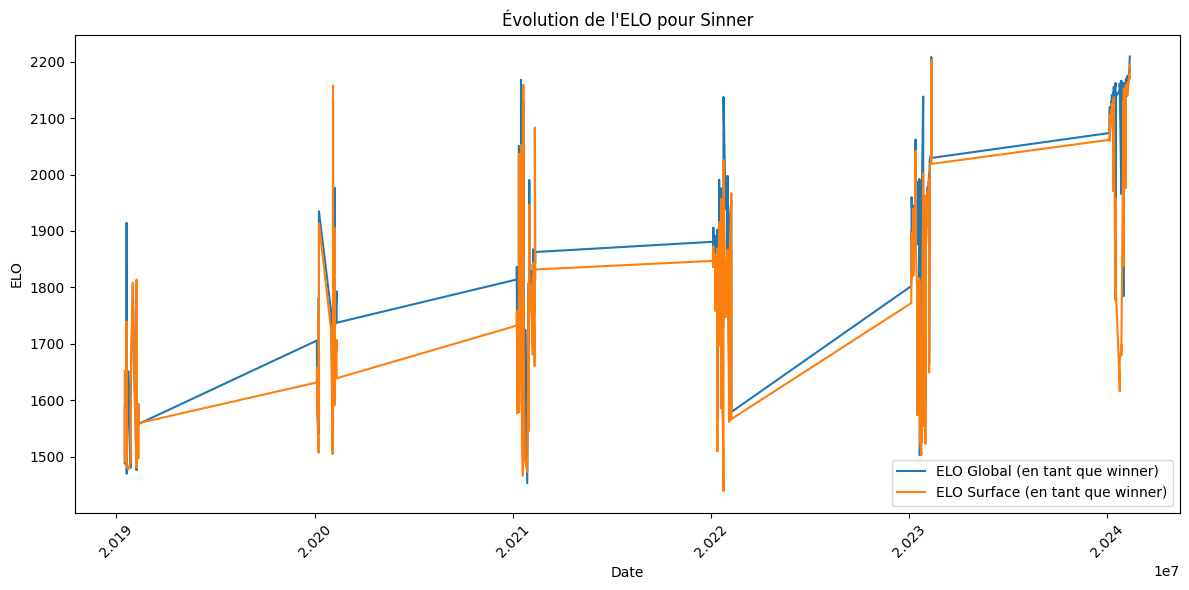

In [33]:
import matplotlib.pyplot as plt

# Exemple pour Sinner
player_name = 'Sinner'
player_df = df[df['winner_name'].str.contains(player_name, case=False) | df['loser_name'].str.contains(player_name, case=False)]
player_df = player_df.sort_values(by='tourney_date')

plt.figure(figsize=(12, 6))
plt.plot(player_df['tourney_date'], player_df['WINNER_ELO_BEFORE'], label='ELO Global (en tant que winner)')
plt.plot(player_df['tourney_date'], player_df['WINNER_ELO_SURFACE_BEFORE'], label='ELO Surface (en tant que winner)')
plt.title(f"√âvolution de l'ELO pour {player_name}")
plt.xlabel("Date")
plt.ylabel("ELO")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

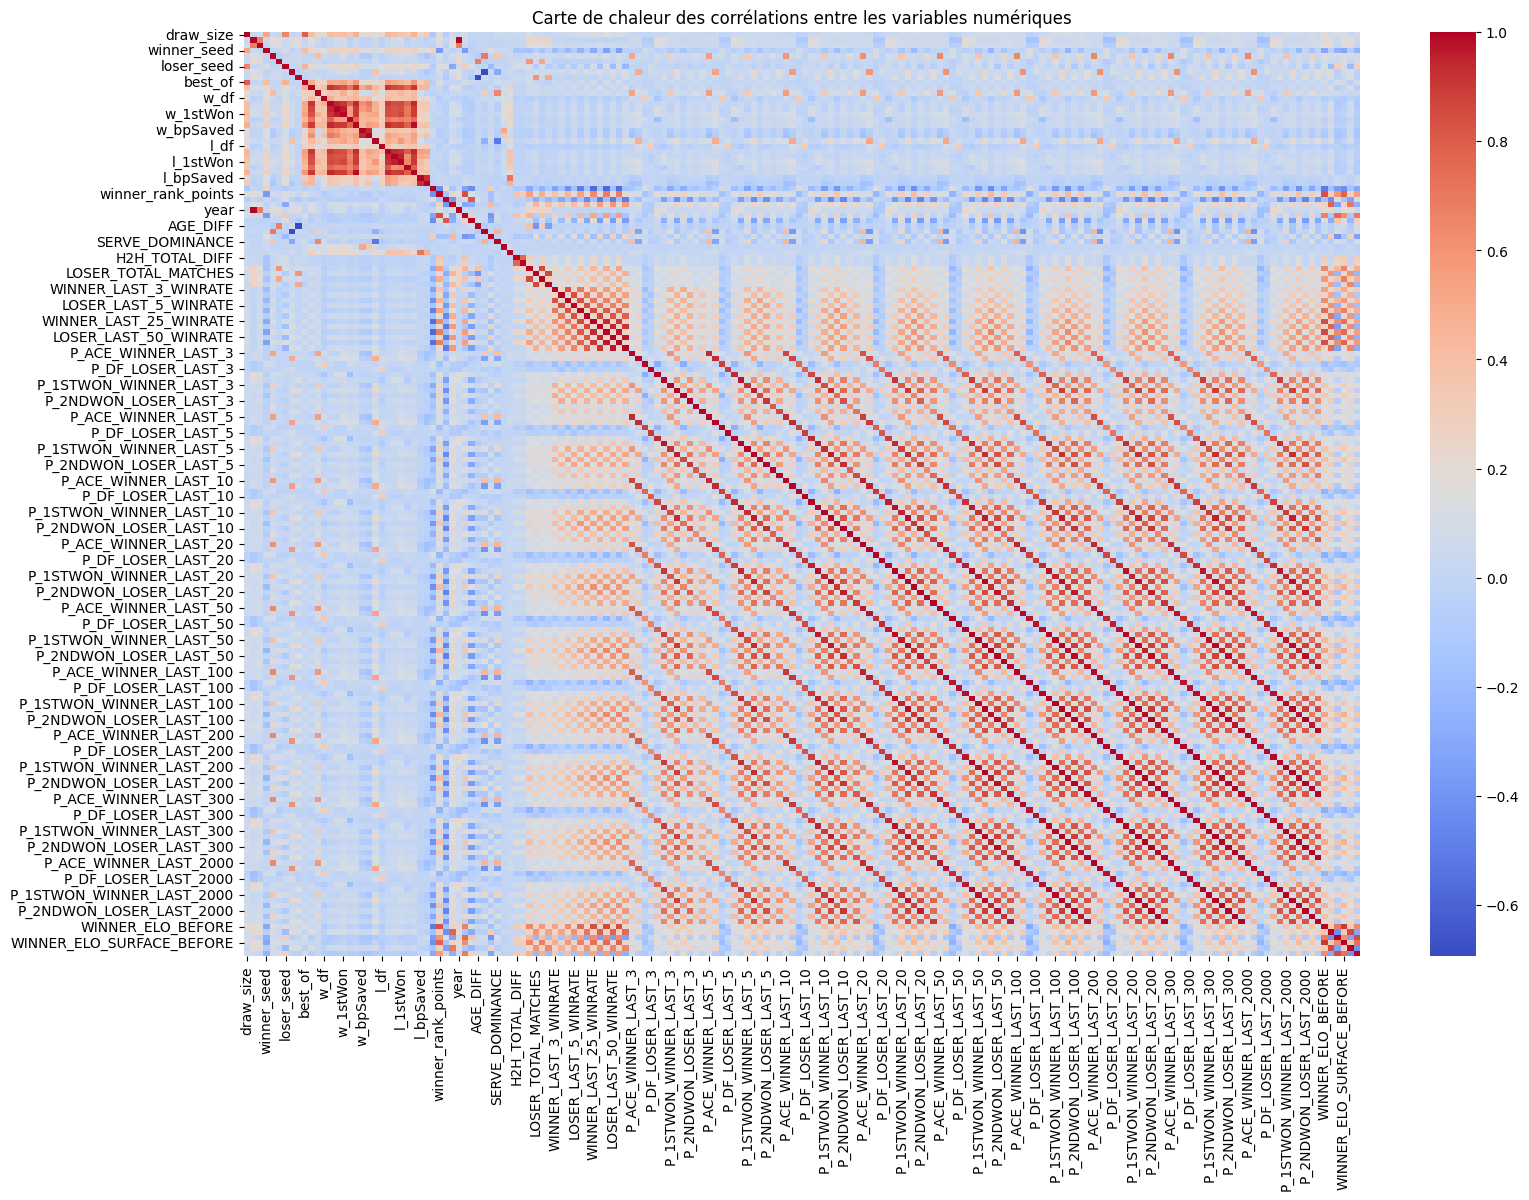

In [34]:
import seaborn as sns

# Garder que les colonnes num√©riques
numeric_cols = df.select_dtypes(include='number').drop(columns=['winner_id', 'loser_id']).copy()
corr = numeric_cols.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Carte de chaleur des corr√©lations entre les variables num√©riques")
plt.show()


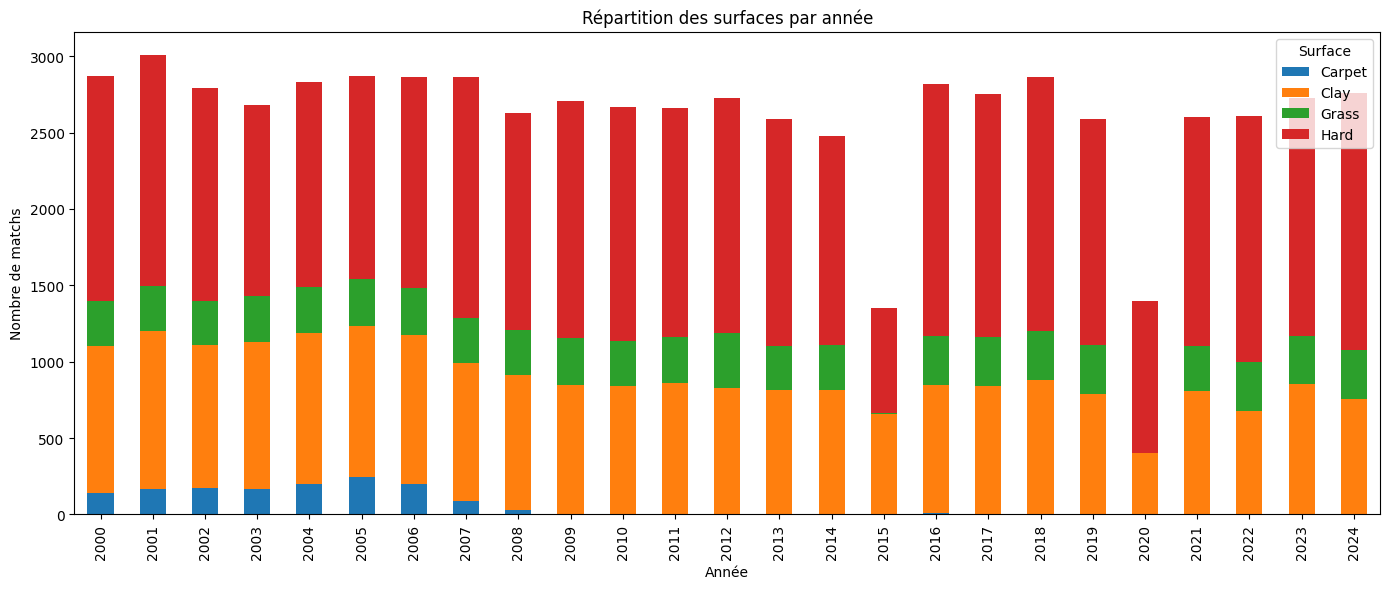

In [35]:
surface_by_year = df.groupby(['year', 'surface_raw']).size().unstack().fillna(0)

surface_by_year.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title("R√©partition des surfaces par ann√©e")
plt.xlabel("Ann√©e")
plt.ylabel("Nombre de matchs")
plt.xticks(rotation=90)
plt.legend(title="Surface")
plt.tight_layout()
plt.show()

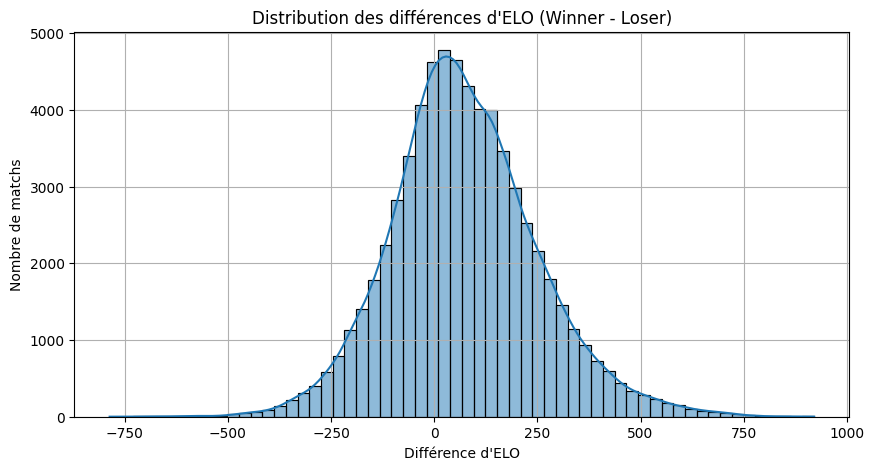

In [36]:
plt.figure(figsize=(10, 5))
sns.histplot(df['ELO_DIFF'], kde=True, bins=60)
plt.title("Distribution des diff√©rences d'ELO (Winner - Loser)")
plt.xlabel("Diff√©rence d'ELO")
plt.ylabel("Nombre de matchs")
plt.grid(True)
plt.show()


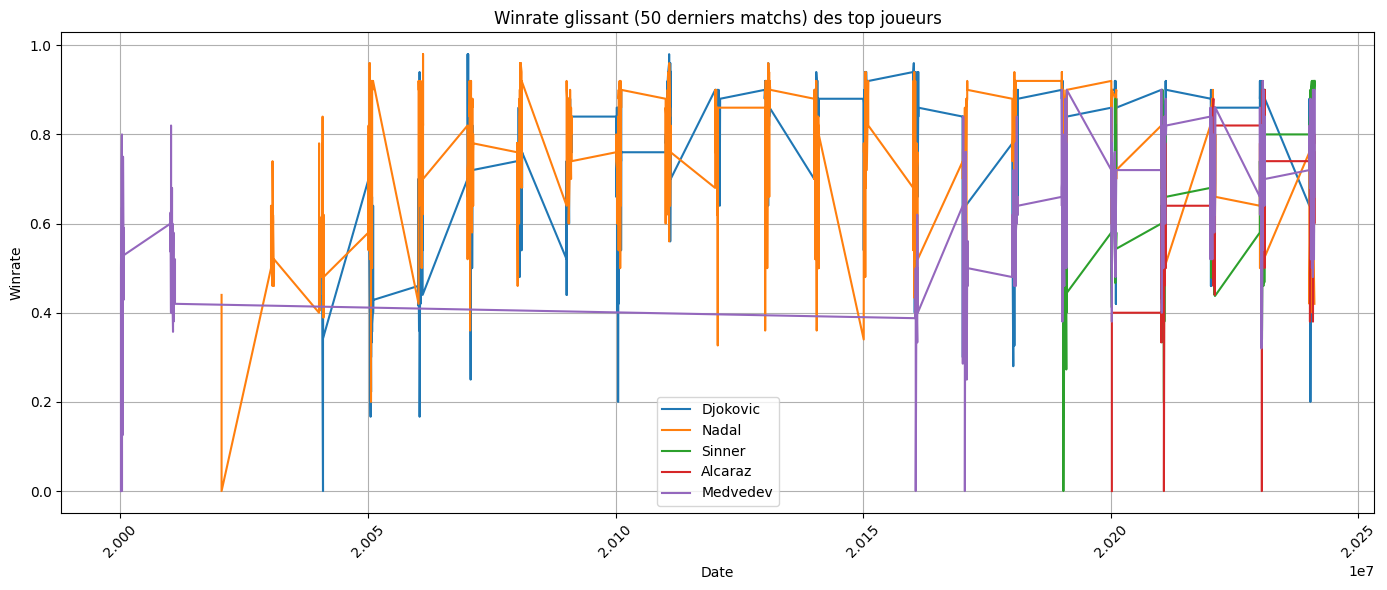

In [37]:
top_players = ['Djokovic', 'Nadal', 'Sinner', 'Alcaraz', 'Medvedev']
plt.figure(figsize=(14, 6))

for name in top_players:
    subset = df[df['winner_name'].str.contains(name, case=False) | df['loser_name'].str.contains(name, case=False)]
    subset = subset.sort_values(by='tourney_date')
    plt.plot(subset['tourney_date'], subset['WINNER_LAST_50_WINRATE'], label=name)

plt.title("Winrate glissant (50 derniers matchs) des top joueurs")
plt.xlabel("Date")
plt.ylabel("Winrate")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


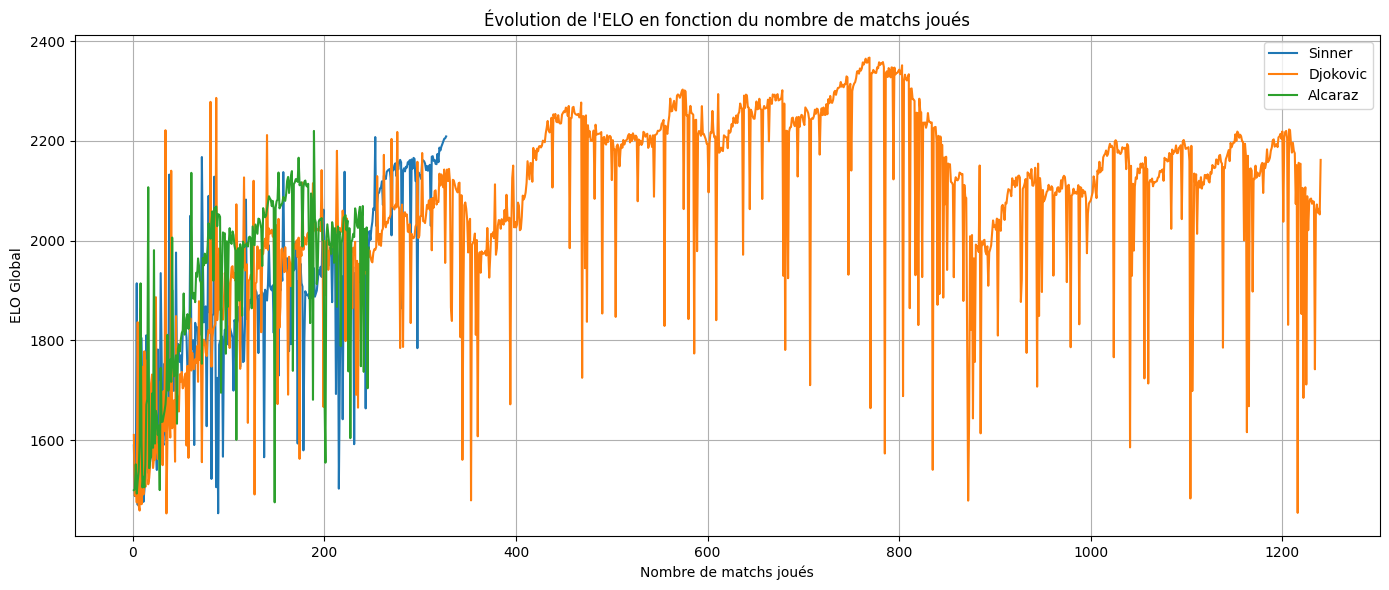

In [38]:
import matplotlib.pyplot as plt

# Choisir un ou plusieurs joueurs
players_to_plot = ['Sinner', 'Djokovic', 'Alcaraz']  # tu peux en ajouter autant que tu veux

plt.figure(figsize=(14, 6))

for name in players_to_plot:
    # Filtrer tous les matchs du joueur (winner ou loser)
    player_matches = df[(df['winner_name'].str.contains(name, case=False)) | 
                        (df['loser_name'].str.contains(name, case=False))].copy()
    
    # Trier par date pour simuler les matchs dans l'ordre chronologique
    player_matches = player_matches.sort_values(by='tourney_date').reset_index(drop=True)
    
    # Cr√©er une colonne "match_count" (x-axis)
    player_matches['match_number'] = range(1, len(player_matches) + 1)
    
    # Tracer l'ELO global
    plt.plot(player_matches['match_number'], player_matches['WINNER_ELO_BEFORE'], label=name)

plt.title("√âvolution de l'ELO en fonction du nombre de matchs jou√©s")
plt.xlabel("Nombre de matchs jou√©s")
plt.ylabel("ELO Global")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---